<a href="https://colab.research.google.com/github/bkkaggle/jax-dcgan/blob/main/dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install flax

import requests
import os
if 'TPU_DRIVER_MODE' not in globals():
  url = 'http://' + os.environ['COLAB_TPU_ADDR'].split(':')[0] + ':8475/requestversion/tpu_driver_nightly'
  resp = requests.post(url)
  TPU_DRIVER_MODE = 1
# The following is required to use TPU Driver as JAX's backend.
import os
from jax.config import config
config.FLAGS.jax_xla_backend = "tpu_driver"
config.FLAGS.jax_backend_target = "grpc://" + os.environ['COLAB_TPU_ADDR']
print(config.FLAGS.jax_backend_target)

     |████████████████████████████████| 163kB 4.9MB/s 
grpc://10.125.182.234:8470


In [2]:
import os
from functools import partial

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

import flax
from flax import linen as nn

import tensorflow as tf
import tensorflow_datasets as tfds

def shard(xs):
    return jax.tree_map(
        lambda x: x.reshape((jax.device_count(), -1) + x.shape[1:]), xs)

class Generator(nn.Module):
    training: bool

    @nn.compact
    def __call__(self, z):
        x = nn.ConvTranspose(features=64*8, kernel_size=(4, 4),
                             strides=(1, 1), padding='VALID', use_bias=False)(z)
        x = nn.BatchNorm(
            use_running_average=not self.training, momentum=0.9)(x)
        x = nn.relu(x)

        x = nn.ConvTranspose(features=64*4, kernel_size=(4, 4),
                             strides=(2, 2), padding='SAME', use_bias=False)(x)
        x = nn.BatchNorm(
            use_running_average=not self.training, momentum=0.9)(x)
        x = nn.relu(x)

        x = nn.ConvTranspose(features=64*2, kernel_size=(4, 4),
                             strides=(2, 2), padding='SAME', use_bias=False)(x)
        x = nn.BatchNorm(
            use_running_average=not self.training, momentum=0.9)(x)
        x = nn.relu(x)

        x = nn.ConvTranspose(features=64, kernel_size=(
            4, 4), strides=(2, 2), padding='SAME', use_bias=False)(x)
        x = nn.BatchNorm(
            use_running_average=not self.training, momentum=0.9)(x)
        x = nn.relu(x)

        x = nn.ConvTranspose(features=1, kernel_size=(
            4, 4), strides=(1, 1), padding='SAME', use_bias=False)(x)
        return jnp.tanh(x)


class Discriminator(nn.Module):
    training: bool

    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=64, kernel_size=(
            4, 4), strides=(2, 2), padding='SAME', use_bias=False)(x)
        x = nn.leaky_relu(x, negative_slope=0.2)

        x = nn.Conv(features=64*2, kernel_size=(4, 4),
                    strides=(2, 2), padding='SAME', use_bias=False)(x)
        x = nn.BatchNorm(
            use_running_average=not self.training, momentum=0.9)(x)
        x = nn.leaky_relu(x, negative_slope=0.2)

        x = nn.Conv(features=64*4, kernel_size=(4, 4),
                    strides=(2, 2), padding='SAME', use_bias=False)(x)
        x = nn.BatchNorm(
            use_running_average=not self.training, momentum=0.9)(x)
        x = nn.leaky_relu(x, negative_slope=0.2)

        x = nn.Conv(features=64*8, kernel_size=(4, 4),
                    strides=(2, 2), padding='SAME', use_bias=False)(x)
        x = nn.BatchNorm(
            use_running_average=not self.training, momentum=0.9)(x)
        x = nn.leaky_relu(x, negative_slope=0.2)

        x = nn.Conv(features=1, kernel_size=(
            1, 1), strides=(4, 4), padding='VALID', use_bias=False)(x)
        x = jnp.reshape(x, [x.shape[0], -1])

        return x


@jax.vmap
def bce_logits_loss(logit, label):
    return jnp.maximum(logit, 0) - logit * label + jnp.log(1 + jnp.exp(-jnp.abs(logit)))


def loss_g(params_g, params_d, batch, rng, variables_g, variables_d):
    z = jax.random.normal(rng, shape=(batch.shape[0], 1, 1, 100))

    fake_batch, variables_g = Generator(training=True).apply(
        {'params': params_g, 'batch_stats': variables_g['batch_stats']}, z, mutable=['batch_stats'])

    fake_logits, variables_d = Discriminator(training=True).apply(
        {'params': params_d, 'batch_stats': variables_d['batch_stats']}, fake_batch, mutable=['batch_stats'])

    real_labels = jnp.ones((batch.shape[0],), dtype=jnp.int32)
    return jnp.mean(bce_logits_loss(fake_logits, real_labels)), (variables_g, variables_d)


def loss_d(params_d, params_g, batch, rng, variables_g, variables_d):
    z = jax.random.normal(rng, shape=(batch.shape[0], 1, 1, 100))

    fake_batch, variables_g = Generator(training=True).apply(
        {'params': params_g, 'batch_stats': variables_g['batch_stats']}, z, mutable=['batch_stats'])

    real_logits, variables_d = Discriminator(training=True).apply(
        {'params': params_d, 'batch_stats': variables_d['batch_stats']}, batch, mutable=['batch_stats'])
    fake_logits, variables_d = Discriminator(training=True).apply(
        {'params': params_d, 'batch_stats': variables_d['batch_stats']}, fake_batch, mutable=['batch_stats'])

    real_labels = jnp.ones((batch.shape[0],), dtype=jnp.int32)
    real_loss = bce_logits_loss(real_logits, real_labels)

    fake_labels = jnp.zeros((batch.shape[0],), dtype=jnp.int32)
    fake_loss = bce_logits_loss(fake_logits, fake_labels)

    return jnp.mean(real_loss + fake_loss), (variables_g, variables_d)


@partial(jax.pmap, axis_name='batch')
def train_step(rng, variables_g, variables_d, optimizer_g, optimizer_d, batch):
    rng, rng_g, rng_d = jax.random.split(rng, 3)

    (g_loss, (variables_g, variables_d)), grad_g = jax.value_and_grad(loss_g, has_aux=True)(
        optimizer_g.target, optimizer_d.target, batch, rng_g, variables_g, variables_d)
    g_loss = jax.lax.pmean(g_loss, axis_name='batch')
    grad_g = jax.lax.pmean(grad_g, axis_name='batch')

    optimizer_g = optimizer_g.apply_gradient(grad_g)

    (d_loss, (variables_g, variables_d)), grad_d = jax.value_and_grad(loss_d, has_aux=True)(
        optimizer_d.target, optimizer_g.target, batch, rng_d, variables_g, variables_d)

    d_loss = jax.lax.pmean(d_loss, axis_name='batch')
    grad_d = jax.lax.pmean(grad_d, axis_name='batch')

    optimizer_d = optimizer_d.apply_gradient(grad_d)

    return rng, variables_g, variables_d, optimizer_g, optimizer_d, d_loss, g_loss


def make_dataset(batch_size, seed=1):
    mnist = tfds.load("mnist")

    def _preprocess(sample):
        image = tf.image.convert_image_dtype(sample["image"], tf.float32)
        image = tf.image.resize(image, (32, 32))
        return 2.0 * image - 1.0

    ds = mnist["train"]
    ds = ds.map(map_func=_preprocess,
                num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.shuffle(10 * batch_size, seed=seed).repeat().batch(batch_size)
    return iter(tfds.as_numpy(ds))


def main():
    dataset = make_dataset(batch_size=256)

    rng = jax.random.PRNGKey(42)
    rng, rng_g, rng_d = jax.random.split(rng, 3)

    init_batch_g = jnp.ones((1, 1, 1, 100), jnp.float32)
    variables_g = Generator(training=True).init(rng_g, init_batch_g)

    init_batch_d = jnp.ones((1, 32, 32, 1), jnp.float32)
    variables_d = Discriminator(training=True).init(rng_d, init_batch_d)

    optimizer_g = flax.optim.Adam(
        learning_rate=1e-4, beta1=0.5, beta2=0.9).create(variables_g["params"])
    optimizer_g = flax.jax_utils.replicate(optimizer_g)

    optimizer_d = flax.optim.Adam(
        learning_rate=1e-4, beta1=0.5, beta2=0.9).create(variables_d["params"])
    optimizer_d = flax.jax_utils.replicate(optimizer_d)

    variables_g = flax.jax_utils.replicate(variables_g)
    variables_d = flax.jax_utils.replicate(variables_d)

    rngs = jax.random.split(rng, num=jax.local_device_count())

    g_losses = []
    d_losses = []

    for i in tqdm(range(2000)):
        img_a = shard(next(dataset))

        rngs, variables_g, variables_d, optimizer_g, optimizer_d, d_loss, g_loss = train_step(
            rngs, variables_g, variables_d, optimizer_g, optimizer_d, img_a)

        if i % 10 == 0:
            g_losses.append(float(jnp.mean(g_loss)))
            d_losses.append(float(jnp.mean(d_loss)))

            if i % 500 == 0:
                rng, rng_sample = jax.random.split(rng)
                z = jax.random.normal(rng_sample, shape=(1, 1, 1, 100))

                temp_params_g = flax.jax_utils.unreplicate(
                    optimizer_g.target)
                temp_variables_g = flax.jax_utils.unreplicate(variables_g)

                samples = Generator(training=False).apply(
                    {'params': temp_params_g, 'batch_stats': temp_variables_g['batch_stats']}, z, mutable=False)

                img = jnp.reshape((samples + 1) / 2, [32, 32])
                plt.imshow(img, cmap='gray')
                plt.show()
    return g_losses, d_losses

In [3]:
print(jax.devices())

[TpuDevice(id=0, host_id=0, coords=(0,0,0), core_on_chip=0), TpuDevice(id=1, host_id=0, coords=(0,0,0), core_on_chip=1), TpuDevice(id=2, host_id=0, coords=(1,0,0), core_on_chip=0), TpuDevice(id=3, host_id=0, coords=(1,0,0), core_on_chip=1), TpuDevice(id=4, host_id=0, coords=(0,1,0), core_on_chip=0), TpuDevice(id=5, host_id=0, coords=(0,1,0), core_on_chip=1), TpuDevice(id=6, host_id=0, coords=(1,1,0), core_on_chip=0), TpuDevice(id=7, host_id=0, coords=(1,1,0), core_on_chip=1)]


local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


  0%|          | 0/2000 [00:00<?, ?it/s]

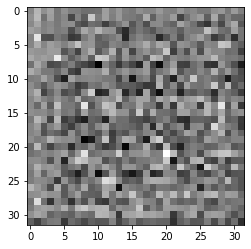

 25%|██▌       | 500/2000 [00:56<01:53, 13.17it/s]

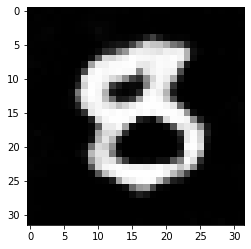

 50%|█████     | 1000/2000 [01:36<01:14, 13.39it/s]

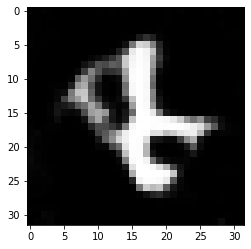

 75%|███████▌  | 1500/2000 [02:15<00:37, 13.35it/s]

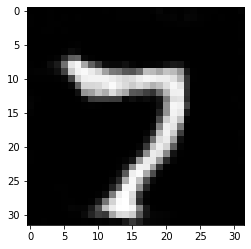

100%|██████████| 2000/2000 [02:54<00:00, 11.46it/s]


In [5]:
g_losses, d_losses = main()

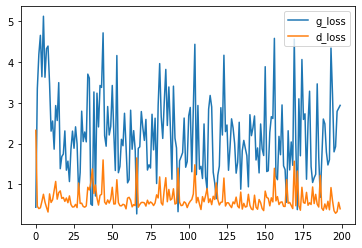

In [6]:
plt.plot(g_losses, label='g_loss')
plt.plot(d_losses, label='d_loss')
plt.legend()
plt.show()